# Illustration of loading a ABF file using pyABF and extracting features using IPFX
This notebook goes through an example of loading in an [Axon Binary Format (ABF) file](http://mdc.custhelp.com/euf/assets/software/FSP_ABFHelp_2.03.pdf) into Python using [pyABF](https://github.com/swharden/pyABF). pyABF is an excellent tool for working with ABF based files in Python. 

After loading in the file and generating a few diagnostic plots, we will then store the sweeps into an [IPFX SweepSet object](https://github.com/AllenInstitute/ipfx/blob/master/ipfx/sweep.py). Then, we will use automated code to extract features from the traces using IPFX tools.

## Load in an ABFv1 file into Python using pyABF and plot example sweeps

The example data file below, <code>13d02049.abf</code> is an ABF version 1 file data. ABFv1 is an older file format (the newer file format is ABFv2). pyABF works well with both ABFv1 and ABFv2

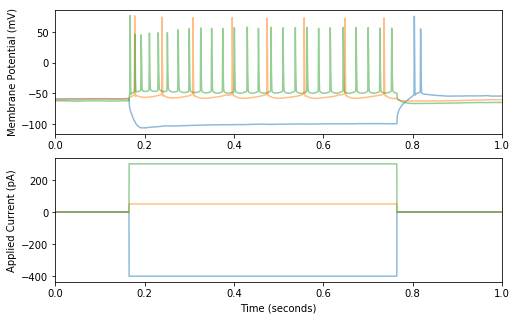

In [2]:
### Import statements
import pyabf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# refers to example_datasets folder in github repo
file_rel_path = 'example_datasets/valiante_lab/'

curr_file = '13d02049.abf'
abf_file_path = file_rel_path + curr_file

abf = pyabf.ABF(abf_file_path) # this is the basic function for accessing abf files

### Configuration variables
stim_channel_num = 0 # on which channel number is the stimulus?
response_chan_num = 0 # on which channel number is the response?

stim_gain = 1000 # integer gain on stimulus
response_gain = 20 # integer gain on response

stim_end = 1 # time point where stimulus ends

sweep_plot_list = [0, 9, 14] # sweeps we want to plot
fig = plt.figure(figsize=(8, 5))

### Figure plotting
for i in sweep_plot_list:
    sweep_num = i
    
    # this setSweep command sets the currently active sweep in the file
    abf.setSweep(sweep_num, channel=response_chan_num)
    # plot the ADC (voltage recording)
    ax1 = fig.add_subplot(211)
    ax1.plot(abf.sweepX, abf.sweepY*response_gain, alpha = .5)

    # plot the DAC (clamp current)
    ax2 = fig.add_subplot(212, sharex=ax1)  
    #abf.setSweep(sweep_num, channel=1)
    ax2.plot(abf.sweepX, abf.sweepC * stim_gain, alpha = .5)

# decorate the plots
ax1.set_ylabel(abf.sweepLabelY)
ax2.set_xlabel(abf.sweepLabelX)
ax2.set_ylabel(abf.sweepLabelC)
ax1.axes.set_xlim(0, stim_end)  # <-- adjust axis like this
plt.show()

## Store sweeps from ABF file into IPFX SweepSet object

We will now format the data from the ABF file into an [IPFX SweepSet object](https://github.com/AllenInstitute/ipfx/blob/master/ipfx/sweep.py). The SweepSet object offers a simple way of storing data from intracellular electrophysiology data. Storing the data into a SweepSet will then allow us to analyze the data easily using IPFX analysis tools.

In [3]:
### Import statements
from ipfx.sweep import Sweep, SweepSet

clamp_mode = "CurrentClamp" # set the clamp mode of the data as Current Clamp

resp_sampling_rate = abf.dataRate # sampling rate in Hertz

sweep_list = list() # initialize an empty list

num_sweeps = abf.sweepCount # number of sweeps

# iterate through all sweeps in file and create IPFX Sweep objects from each sweep,
# a SweepSet is initialized from a list of Sweep objects
for i in range(0, num_sweeps):
    sweep_num = i
    abf.setSweep(sweep_num, channel=response_chan_num)

    time_vec = abf.sweepX
    response_vec = abf.sweepY*response_gain
    

    abf.setSweep(sweep_num, channel=stim_channel_num)
    stim_vec = abf.sweepC * stim_gain


    sweep = Sweep(t=time_vec,
                  v=response_vec,
                  i=stim_vec,
                  sampling_rate=resp_sampling_rate,
                  sweep_number=i,
                  clamp_mode=clamp_mode,
                  #epochs = curr_epoch
                  )
    sweep_list.append(sweep)
sweep_set = SweepSet(sweep_list) # this is the SweepSet object that has the data from the ABF file

## Set up IPFX Feature Extractors to work on ABF-based SweepSet object

We will now set up the Feature Extractors to operate on the <code>sweep_set</code> object that we created.

In [4]:
from ipfx.feature_extractor import SpikeTrainFeatureExtractor, SpikeFeatureExtractor
from ipfx.stimulus_protocol_analysis import LongSquareAnalysis

start_time = .2 # start time of stimulus
end_time = 1 # end time of stimulus

bessel_filter_khz = 1
subthresh_min_amp = -500 # what minimum stimulus amplitude (in pA) to consider for analysis

spike_extractor = SpikeFeatureExtractor(start=start_time, end=end_time, filter = bessel_filter_khz)
spike_train_extractor = SpikeTrainFeatureExtractor(start=start_time, end=end_time, baseline_interval = .05)

# Create the analysis object
lsa = LongSquareAnalysis(spx=spike_extractor,
                         sptx=spike_train_extractor,
                         subthresh_min_amp= subthresh_min_amp 
                        )

## Extract electrophysiology features automatically using the IPFX Feature Extractors

In [5]:

# We can analyze features using a single line below!
lsa_results = lsa.analyze(sweep_set)

# lsa_results has a lot of information that was extracted automatically!
print(lsa_results)

{'spikes_set': [   threshold_index  clipped  threshold_t  threshold_v  threshold_i  \
0             8027    False       0.8027    -51.99585          0.0   
1             8167    False       0.8167    -47.98584          0.0   

   peak_index  peak_t     peak_v  peak_i  trough_index  ...  adp_index  adp_t  \
0        8039  0.8039  75.463867     0.0          8060  ...        NaN    NaN   
1        8180  0.8180  54.943848     0.0          8830  ...        NaN    NaN   

   adp_v  adp_i  slow_trough_index  slow_trough_t  slow_trough_v  \
0    NaN    NaN                NaN            NaN            NaN   
1    NaN    NaN                NaN            NaN            NaN   

   slow_trough_i   width  upstroke_downstroke_ratio  
0            NaN  0.0010                   1.463889  
1            NaN  0.0011                   1.591453  

[2 rows x 36 columns],    threshold_index  clipped  threshold_t  threshold_v  threshold_i  \
0             8051    False       0.8051   -52.026367          0.0  

## Format extracted features into a nice Python dictionary object

In [6]:
def summarize_cell_ephys_features(lsa_results):
    hero_keep_features = ['adapt', 'avg_rate', 'first_isi', 'isi_cv', 'latency', 'mean_isi', 'median_isi', 
                          'stim_amp']
    rheo_keep_features = ['threshold_v', 'peak_v', 'trough_v', 
     'fast_trough_v', 'adp_v', 'width', 'upstroke_downstroke_ratio', 'peak_t', 'fast_trough_t', 'trough_t']
    
    overall_cell_keep_features = ['v_baseline', 'rheobase_i', 'fi_fit_slope', 
                                  'sag', 'vm_for_sag', 'input_resistance', 'tau']
    
    hero_small_dict = lsa_results['hero_sweep'][hero_keep_features]
    rheobase_sweep_index = lsa_results['rheobase_sweep'].name
    rheobase_sweep = lsa_results['spikes_set'][rheobase_sweep_index].iloc[0]
    
    rheo_spike_small_dict = rheobase_sweep[rheo_keep_features]
    rheo_first_isi = lsa_results['rheobase_sweep']['first_isi']
    rheo_spike_small_dict['rheo_first_isi'] = rheo_first_isi

    spike_comb_dict = {**hero_small_dict, **rheo_spike_small_dict}

    overall_cell_features = {x: lsa_results[x] for x in overall_cell_keep_features if x in lsa_results}
    final_cell_feature_dict = {**spike_comb_dict, **overall_cell_features}
    return(final_cell_feature_dict)

In [7]:
summarized_cell_features = summarize_cell_ephys_features(lsa_results)
summarized_cell_features

{'adapt': 0.017486367539321156,
 'avg_rate': 15.0,
 'first_isi': 0.03839999999999999,
 'isi_cv': 0.09084788343250925,
 'latency': 0.003500000000000003,
 'mean_isi': 0.04906363636363637,
 'median_isi': 0.04909999999999998,
 'stim_amp': 100.00000149011612,
 'threshold_v': -51.446533,
 'peak_v': 74.32861,
 'trough_v': -57.348633,
 'fast_trough_v': -54.083252,
 'adp_v': -53.375244140625,
 'width': 0.0010999999999999899,
 'upstroke_downstroke_ratio': 1.4908692157461392,
 'peak_t': 0.2386,
 'fast_trough_t': 0.24100000000000002,
 'trough_t': 0.2637,
 'rheo_first_isi': 0.06940000000000002,
 'v_baseline': -63.17798411051432,
 'rheobase_i': 50.00000074505806,
 'fi_fit_slope': 0.03801020351523649,
 'sag': 2.809475898742676,
 'vm_for_sag': -69.940186,
 'input_resistance': 136.96334634775883,
 'tau': nan}